![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

# import

In [1]:
import numpy as np
import pandas as pd
import ast

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

from datetime import datetime

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

## Посмотрим на колличественные характеристики данных 

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [12]:
# Приведем названия признаков в общему виду, для более удобной работы
data.columns = ['_'.join(col.split()).lower() for col in data.columns]

In [13]:
# Посмотрим на уникальность данных
data.nunique()

restaurant_id        13094
city                    31
cuisine_style        10731
ranking              12975
price_range              3
number_of_reviews     1573
reviews              41857
url_ta               49963
id_ta                49963
sample                   2
rating                  10
dtype: int64

Как видно, такие признаки как `Restaurant_id`, `URL_TA`, `ID_TA`, которые якобы должны быть уникальными, имеют дубли.  
Возможные причины:  
- ошибки в данных, например, если датасет собирался из разных источников.
- ресторан является сетевым и под одним id находится несколько ресторанов в разных локациях.

In [14]:
# Посмотрим на данные
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
17874,id_8244,London,"['Cafe', 'Mediterranean']",8253.0,$,10.0,"[['Sweet memorable place', 'An Hampstead insti...",/Restaurant_Review-g186338-d7337074-Reviews-Ta...,d7337074,1,4.5
9020,id_9020,Lisbon,"['European', 'Portuguese']",2089.0,NaN,2.0,[['Very good historical and architectural spo....,/Restaurant_Review-g189158-d4591421-Reviews-Sa...,d4591421,0,0.0
43291,id_4067,Prague,['Fast Food'],4081.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274707-d7124068-Reviews-Ci...,d7124068,1,2.0
39670,id_12450,London,NaN,12460.0,NaN,NaN,"[['Quick drink after the cricket'], ['06/08/20...",/Restaurant_Review-g186338-d12526149-Reviews-R...,d12526149,1,4.0
15519,id_1407,Dublin,['European'],1411.0,$,7.0,"[['Pizza @ Vanilladu', 'Pizza and wine'], ['11...",/Restaurant_Review-g186605-d10788736-Reviews-V...,d10788736,1,4.0


# Cleaning and Preparing Data

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


## 1. Обработка NAN

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


### Признак **number_of_reviews**

In [17]:
# Создадим сначала булевый признак является ли значение реальным или искусственным
data['number_of_reviews_isNAN'] = pd.isna(data['number_of_reviews']).astype('uint8')

In [18]:
# Заполним пропуски средним значением по городу.
# Для этого посчитаем среднее значение кол-во отзывов по городам
mean_num_rev = data.groupby('city').number_of_reviews.mean()

data.number_of_reviews = data.apply(lambda row: mean_num_rev[row['city']] if pd.isnull(row['number_of_reviews']) \
                                                                             else row['number_of_reviews'], axis=1)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              38410 non-null object
ranking                    50000 non-null float64
price_range                32639 non-null object
number_of_reviews          50000 non-null float64
reviews                    49998 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
number_of_reviews_isNAN    50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(1)
memory usage: 4.2+ MB


### Признак **price_range**

In [20]:
# Посмотрим на частотность распределения значений признака price_range
data.price_range.value_counts(ascending=False)

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [21]:
# Создадим сначала булевый признак является ли значение реальным или искусственным
data['price_range_isNAN'] = pd.isna(data['price_range']).astype('uint8')

# Видно что значение среднего уровня цен более чем в 3 раза выше остальных.
# Заполним пропуски средним значением, далее оценик как это сказалось на качестве модели.
data.price_range = data.price_range.fillna(value='$$ - $$$')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              38410 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          50000 non-null float64
reviews                    49998 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
number_of_reviews_isNAN    50000 non-null uint8
price_range_isNAN          50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(2)
memory usage: 4.3+ MB


### Признак **reviews**

In [23]:
data.reviews.value_counts()

[[], []]                                                                                                                              8112
[['Visited the rooftop bar', 'SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...'], ['06/27/2017', '10/31/2017']]                             2
[['Sat night', 'Can\'t even explain.. "A" place.. A "100...'], ['10/22/2017', '05/11/2017']]                                             2
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]                                           2
                                                                                                                                      ... 
[['A late find!', 'Lunch stop'], ['11/13/2017', '10/21/2017']]                                                                           1
[['Outstanding!', 'Absolute

Видно, что 8112 строк в признаке reviews имеют пустое значение `[[], []]`
Заменим это значение на np.nan 

In [24]:
data.reviews = data.reviews.apply(lambda string: np.nan if string == '[[], []]' else string)

In [25]:
# Сами текста отзывов обрабатывать не будем, но будем использовать из даты, создадим дополнительный булевый признак
# `reviews_isNAN`
data['reviews_isNAN'] = pd.isna(data['reviews']).astype('uint8')

### Признак **cuisine_style**

In [26]:
# Создадим булевый признак ялвяется ли значение реальным или добавленно искусственно в процессе обработки данных
data['cuisine_style_isNAN'] = pd.isna(data['cuisine_style']).astype('uint8')

In [27]:
# Пропуски в cuisine_style заменим на тип traditional, то есть традиционная кухня
data.cuisine_style = data.cuisine_style.fillna(value='traditional')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              50000 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          50000 non-null float64
reviews                    41886 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
number_of_reviews_isNAN    50000 non-null uint8
price_range_isNAN          50000 non-null uint8
reviews_isNAN              50000 non-null uint8
cuisine_style_isNAN        50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(4)
memory usage: 4.4+ MB


## 2. Создание новых признаков


###  Создадим признак **cuisine_count** - кол-во кухонь в ресторане

In [29]:
def get_cuisine_list(string):
    """
    Очищает строку от не буквенных символов и
    возвращает список слов.
    """
    cuisine_list = string.replace('[', '') \
                .replace(']', '') \
                .replace("'", "") \
                .split(', ')
    
    return cuisine_list


def count_cuisine(cuisine_str):
    """
    Возвращает кол-во кухонь в ресторане
    """
    
    return len(get_cuisine_list(cuisine_str))

In [30]:
data['cuisine_count'] = data.cuisine_style.map(count_cuisine)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              50000 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          50000 non-null float64
reviews                    41886 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
number_of_reviews_isNAN    50000 non-null uint8
price_range_isNAN          50000 non-null uint8
reviews_isNAN              50000 non-null uint8
cuisine_style_isNAN        50000 non-null uint8
cuisine_count              50000 non-null int64
dtypes: float64(3), int64(2), object(7), uint8(4)
memory usage: 4.8+ MB


### Создание новых временных признаков 

In [32]:
def clean_and_format_date(str_date):
    """
    Преобразует строку дату в формат
    03/18/2020
    """
    months = {
        'January': '01',
        'February': '02',
        'March': '03',
        'April': '04',
        'May': '05',
        'June': '06',
        'July': '07',
        'August': '08',
        'September': '09',
        'October': '10',
        'November': '11',
        'December': '12',
        
    }
    
    date = str_date.replace("'", "") \
                       .replace(',', '') \
                       .replace('/', ' ')  \
                       .split(' ')
                       
    if date[0].isdigit():
        return '/'.join(date)
    
    date[0] = months[date[0]]
    new_date = '/'.join(date)
    return new_date


def get_list_of_dates_list(string):
    """
    Возвращаем список строк, очищенных от
    не буквенных символов.
    """
    return string.split('], [')[1] \
                 .replace(']]', '') \
                 .split("', '")


def get_dates(review):
    """
    Возвращает сконкатеннированную строку дат
    в виде '01/01/2010 | 02/02/2020'
    """
    if pd.isnull(review):
        return np.nan
    
    if review == '[[], []]':
        return np.nan
    
    dates = get_list_of_dates_list(review)
    clean_dates = [clean_and_format_date(date) for date in dates]
    clean_dates.reverse()
    return ' | '.join(clean_dates)


def get_dates_list(string):
    """
    разбивает строку на подстроки с датами и 
    преобразует из к типу datetime
    Возвращает список экземпляров класса datetime.
    """
    dates_list = string.split(' | ')
    dates = [datetime.strptime(date, "%m/%d/%Y") for date in dates_list]
    
    return dates
    

def get_date_review(string, first=True):
    """
    Функция возвращает либо первую, либо последную строку даты самую раннюю дату из строки
    Если переданное значение равно np.nan, или кол-во дать в строке равно 1,
    то возвращает заведомо заданное значение 01/01/1990
    """
    
    if string == '01/01/1800':
        return '01/01/1800'
    else:
        dates = get_dates_list(string)
    
    if first:
        date = min(dates)
    else:
        date = max(dates)
        
    return datetime.strftime(date, "%m/%d/%Y")
        
    

### Создадим временный признак **dates_of_reviews** для более удобной работы с датами 

In [33]:
data['dates_of_reviews'] = data.reviews.map(get_dates)

In [34]:
# Создадим булевый признак ялвяется ли значение реальным или добавленно искусственно в процессе обработки данных
data['dates_of_reviews_isNAN'] = pd.isna(data['dates_of_reviews']).astype('uint8')

In [35]:
# Заполним пропуски в признаке dates_of_reviews списком из двух одинаковых дат '01/01/2015 | 01/01/2015'
data.dates_of_reviews = data.dates_of_reviews.fillna(value='01/01/2015 | 01/01/2015')

### Создадим признаки самого последнего отзывы и первого 

In [36]:
# first_review_date - дата первого отзыва
# last_review_date - дата последнего отзыва
data['first_review_date'] = data.dates_of_reviews.apply(get_date_review, first=True)
data['last_review_date'] = data.dates_of_reviews.apply(get_date_review, first=False)

In [37]:
# Приведем полученные признаки к типу данных datetime
for col in ['first_review_date', 'last_review_date']:
    data[col] = pd.to_datetime(data[col], format="%m/%d/%Y")

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              50000 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          50000 non-null float64
reviews                    41886 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
number_of_reviews_isNAN    50000 non-null uint8
price_range_isNAN          50000 non-null uint8
reviews_isNAN              50000 non-null uint8
cuisine_style_isNAN        50000 non-null uint8
cuisine_count              50000 non-null int64
dates_of_reviews           50000 non-null object
dates_of_reviews_isNAN     50000 non-null uint8
first_review_

### Создадим признак **days_between_reviews**

In [39]:
data['days_between_reviews'] = (data.last_review_date - data.first_review_date).dt.days

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              50000 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          50000 non-null float64
reviews                    41886 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
number_of_reviews_isNAN    50000 non-null uint8
price_range_isNAN          50000 non-null uint8
reviews_isNAN              50000 non-null uint8
cuisine_style_isNAN        50000 non-null uint8
cuisine_count              50000 non-null int64
dates_of_reviews           50000 non-null object
dates_of_reviews_isNAN     50000 non-null uint8
first_review_

### Создадим признак **restaurants_count** - кол-во ресторанов в городе

In [41]:
# Создадим справочник с указанием количества ресторанов для каждого города, присутствующего в датасете
restaurant_stat_data = {
    'Paris': 17593,
    'Stockholm': 3131,
    'London': 22366,
    'Berlin': 8110, 
    'Munich': 3367,
    'Oporto': 2060, 
    'Milan': 7940,
    'Bratislava': 1331,
    'Vienna': 4387, 
    'Rome': 12086,
    'Barcelona': 10086,
    'Madrid': 11562,
    'Dublin': 2706,
    'Brussels': 3703,
    'Zurich': 1901,
    'Warsaw': 3210,
    'Budapest': 3445, 
    'Copenhagen': 2637,
    'Amsterdam': 4189,
    'Lyon': 2833,
    'Hamburg': 3501, 
    'Lisbon': 4985,
    'Prague': 5850,
    'Oslo': 1441, 
    'Helsinki': 1661,
    'Edinburgh': 2248,
    'Geneva': 1753,
    'Ljubljana': 647,
    'Athens': 2814,
    'Luxembourg': 759,
    'Krakow': 1832       
}

In [42]:
data['restaurants_count'] = data.city.map(restaurant_stat_data)

### Создадим признак **ranking_proportion** - отношение признака ranking и restaurants_count

In [43]:
data['ranking_proportion'] = data.ranking / data.restaurants_count

### Преобразуем признак price_range по принципу LabelEncoding

In [44]:
price_dict = {
    '$': 1,
    '$$ - $$$': 100,
    '$$$$': 1000
}

data.price_range = data.price_range.map(price_dict)

In [45]:
### Создадим признак **is_capital_city** - является ли город столицей страны или нет.
# Создадим словарь, в котором ключами буду названия городов, а значениями True, если этот город столица, в противном случае False
is_capital = {
    'London': True,
    'Paris': True,
    'Madrid': True,
    'Barcelona': False,
    'Berlin': True,
    'Milan': False,
    'Rome': True,
    'Prague': True,
    'Lisbon': True,
    'Vienna': True,
    'Amsterdam': True,
    'Brussels': True,
    'Hamburg': False,
    'Munich': False,
    'Lyon': False,
    'Stockholm': True,
    'Budapest': True,
    'Warsaw': True,
    'Dublin': True,
    'Copenhagen': True,
    'Athens': True,
    'Edinburgh': True,
    'Zurich': True,
    'Oporto': False,
    'Geneva': True,
    'Krakow': True,
    'Oslo': True,
    'Helsinki': True,
    'Bratislava': True,
    'Luxembourg': True,
    'Ljubljana': True
}


# Создадим числовой признак, является ли город столицей
data['is_capital_city'] = data['city'].map(is_capital)

### Исследуем данные

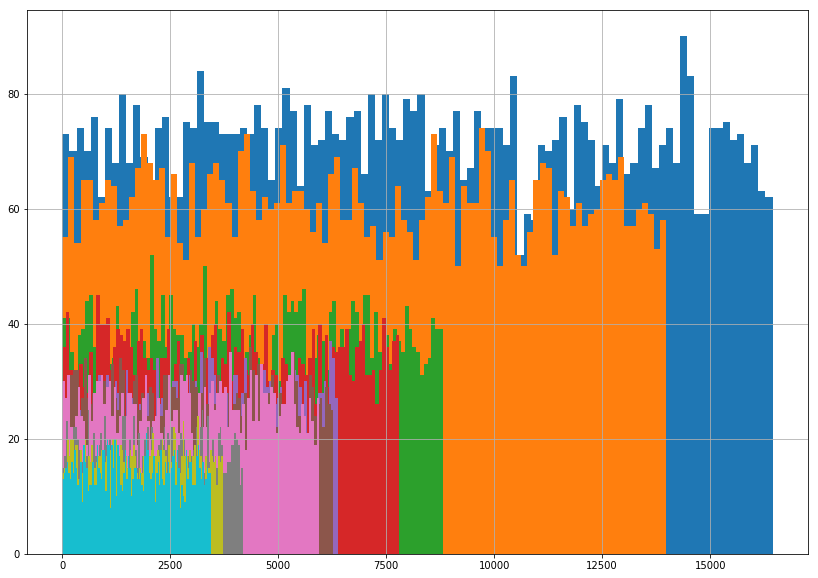

In [46]:
plt.rcParams['figure.figsize'] = (14,10)

# посмотрим на топ 10 городов
for x in (data['city'].value_counts())[0:10].index:
    data['ranking'][data['city'] == x].hist(bins=100)
plt.show()

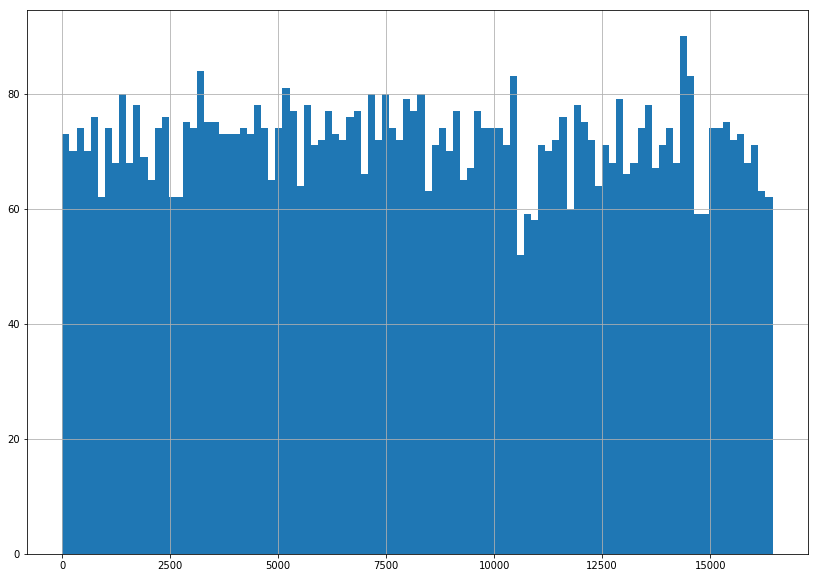

In [47]:
data['ranking'][data['city'] == 'London'].hist(bins=100)

## Создание dummy-признаков
### Преобразуем признаки **city** и **cuisine_style** 

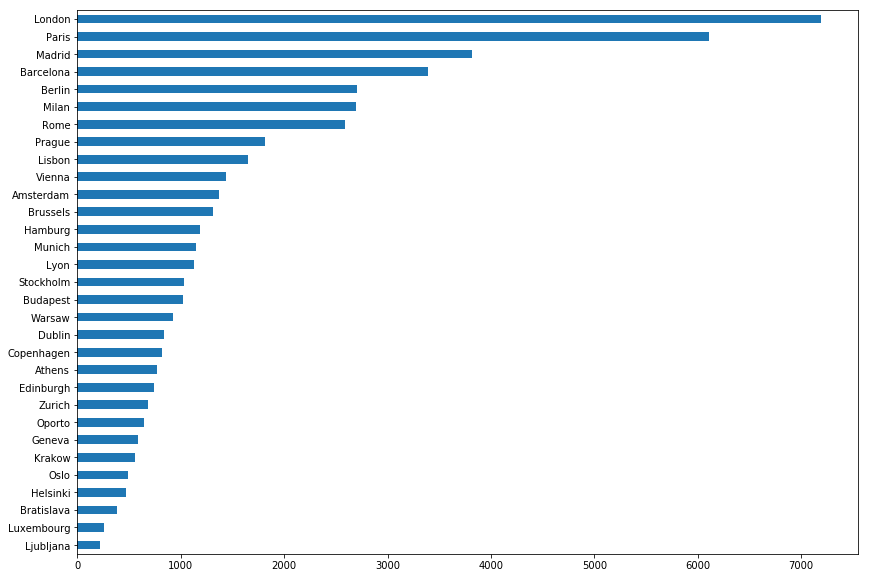

In [48]:
# Посмотрим на признак city
data['city'].value_counts(ascending=True).plot(kind='barh')

Получается, что ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

In [49]:
# Кодпирование признака city
data = pd.get_dummies(data, columns=['city'])

In [50]:
def get_unique_cuisines():
    """
    Возвращает список уникальных значений
    типов кухонь
    """
    all_cuisines = []

    cuisine_styles = data.cuisine_style.to_list()

    for styles in cuisine_styles:
        all_cuisines += get_cuisine_list(styles)

    return list(set(all_cuisines))



# Ohe-кодирование признака cuisine_style
for i in get_unique_cuisines():
    data[f"cuisine_style_{i}"] = (data.cuisine_style.str.contains(i)).astype(float)
data.drop(['cuisine_style'], inplace=True, axis=1)


# EDA 

### Посмотрим распределение признака

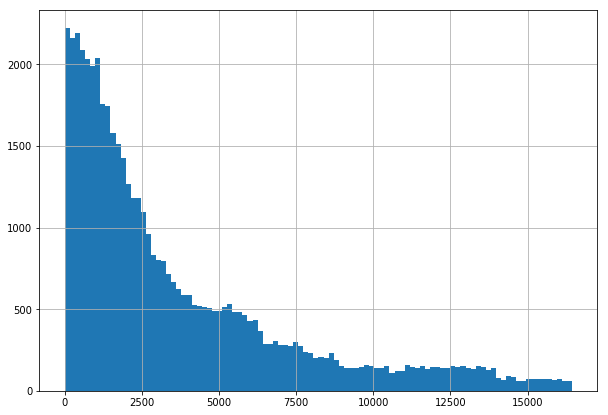

In [51]:
plt.rcParams['figure.figsize'] = (10,7)
data['ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

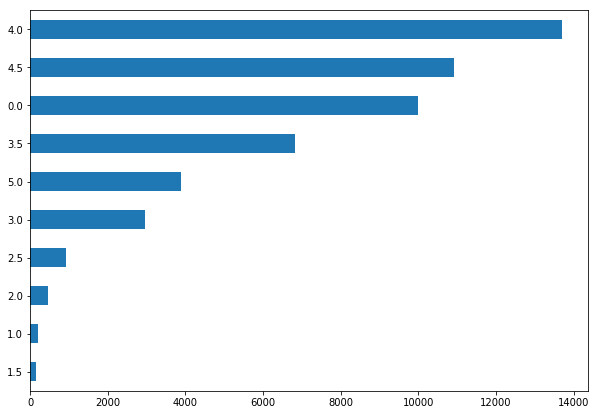

In [52]:
data['rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

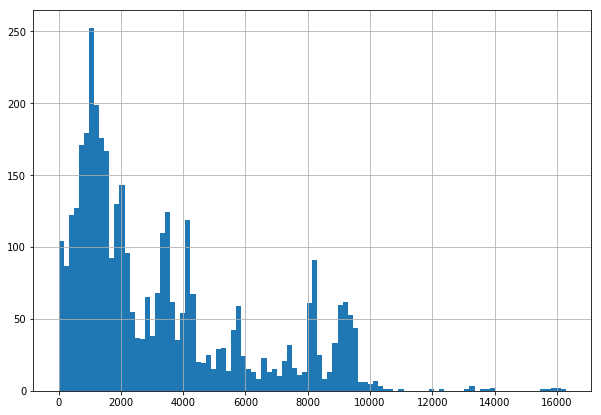

In [53]:
data['ranking'][data['rating'] == 5].hist(bins=100)

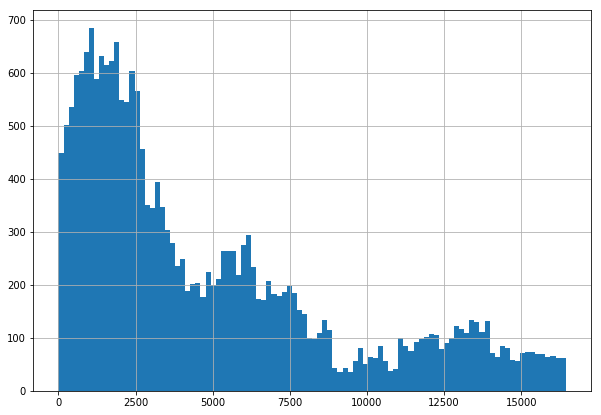

In [54]:
data['ranking'][data['rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

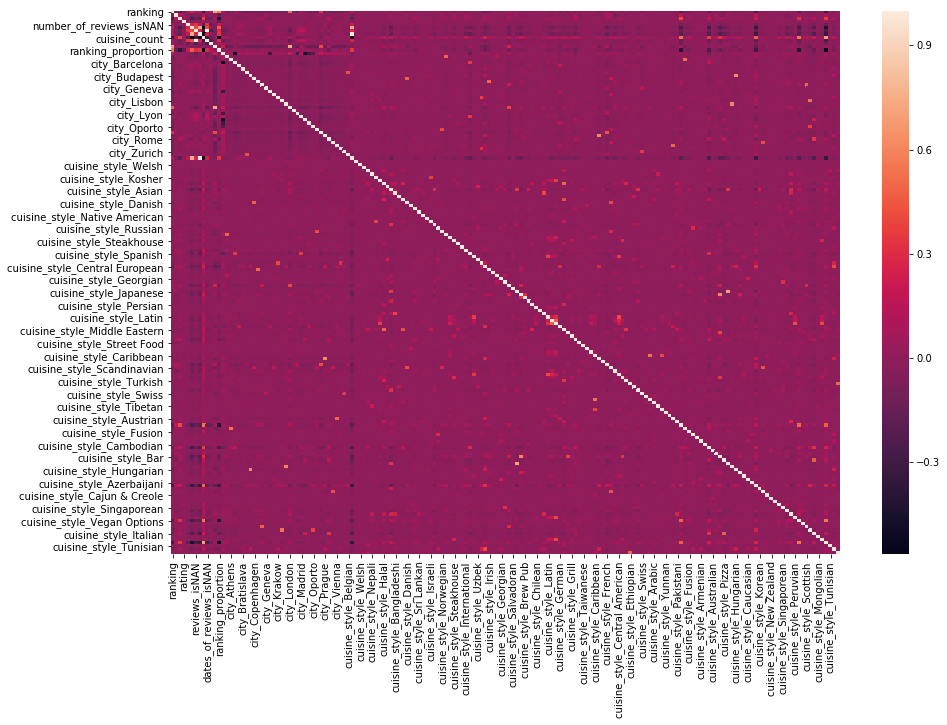

In [55]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [56]:
# на всякий случай, заново подгружаем данные
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

In [57]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [58]:
# df_preproc = preproc_data(data)
df_preproc = data.copy(deep=True)
df_preproc.is_capital_city = df_preproc.is_capital_city.astype('uint8')
# df_preproc.sample(10)

In [59]:
# Отберем числовые признаки для обучения модели
columns_part_1 = 'ranking price_range number_of_reviews rating number_of_reviews_isNAN price_range_isNAN reviews_isNAN cuisine_style_isNAN ' \
                 'cuisine_count sample'.split()
columns_part_2 = list(df_preproc.columns[18:])
pre_columns = columns_part_1 + columns_part_2
df_preproc = df_preproc[pre_columns]
df_preproc.shape

(50000, 171)

In [60]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [61]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [62]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 170), (40000, 170), (40000, 169), (32000, 169), (8000, 169))

# Model 
Сам ML

In [63]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [64]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [65]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [66]:
# Видим разницу в том, что реальные рейтинги всегда кратны 0.5
# Напишем функцию соответствующей корректировки предсказанных рейтингов
def fine_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

In [67]:
# Применим такое округление
for i in range(len(y_pred)):
    y_pred[i] = fine_rating_pred(y_pred[i])

In [68]:
y_pred

array([4.5, 4.5, 4.5, ..., 4.5, 4. , 4. ])

In [69]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1763125


In [70]:
# MAE: 0.1763125

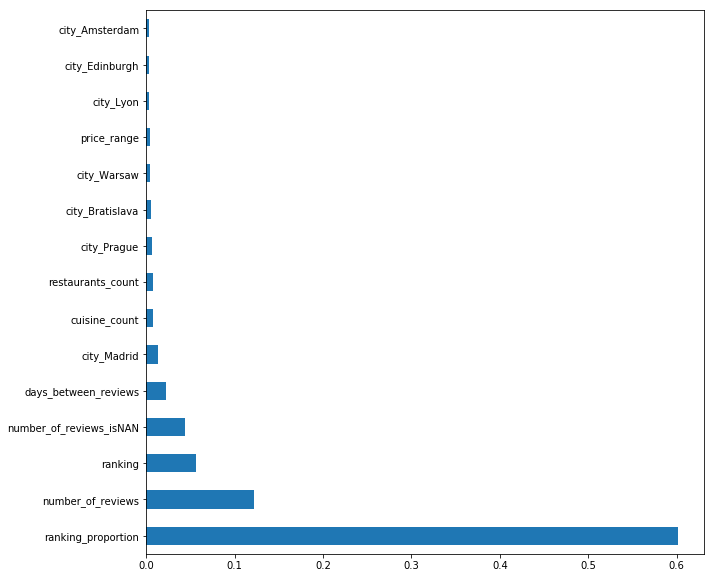

In [71]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [72]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,rating,number_of_reviews_isNAN,price_range_isNAN,reviews_isNAN,cuisine_style_isNAN,cuisine_count,days_between_reviews,...,cuisine_style_Delicatessen,cuisine_style_Scottish,cuisine_style_Portuguese,cuisine_style_Italian,cuisine_style_Mongolian,cuisine_style_Argentinean,cuisine_style_Vegetarian Friendly,cuisine_style_Tunisian,cuisine_style_Eastern European,cuisine_style_African
8113,6716.0,100,12.000000,0.0,0,0,1,0,4,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6061,1270.0,100,45.318182,0.0,1,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6235,309.0,100,56.000000,0.0,0,0,0,0,1,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2895,2004.0,100,108.000000,0.0,0,0,0,0,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8662,7772.0,100,23.000000,0.0,0,1,0,1,1,64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293,1805.0,100,4.000000,0.0,0,1,0,0,1,632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7415,1091.0,100,366.000000,0.0,0,0,0,0,6,196,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4439,2646.0,1,8.000000,0.0,0,0,0,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1525,5062.0,100,63.772188,0.0,1,1,0,0,5,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3364,6257.0,100,2.000000,0.0,0,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
test_data = test_data.drop(['rating'], axis=1)

In [74]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [75]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [76]:
# Применим округление
for i in range(len(predict_submission)):
    predict_submission[i] = fine_rating_pred(predict_submission[i])

In [77]:
predict_submission

array([3.5, 4. , 4.5, ..., 3. , 4.5, 4. ])

In [78]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
